In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import cmocean 
import cartopy.crs as ccrs 
import numpy as np 
import os
import matplotlib
from matplotlib.colors import LinearSegmentedColormap as LSC
import pyresample
import scipy.stats as stats
import sys
from scipy import fftpack


In [2]:
#GOALS: 
#Correlation matrix between the ngpus and the norksy800
#Spectral analysis between the ngpus and the norkyst800
#plot f/h as contourlines with u & v
ds_ngpus = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/experiments/ngpus-2017-24/inference/lam-48h-step_002016.nc')
ds_norkyst = xr.open_mfdataset(['/lustre/storeB/project/fou/hi/roms_hindcast/norkyst_v3/sdepth/2024/04/norkyst800-20240402.nc', '/lustre/storeB/project/fou/hi/roms_hindcast/norkyst_v3/sdepth/2024/04/norkyst800-20240403.nc']).isel(s_rho=-1)


In [3]:
ds_norkyst
#ds_ngpus

<xarray.Dataset> Size: 56GB
Dimensions:           (time: 48, Y: 1148, X: 2747, s_w: 41)
Coordinates:
  * time              (time) datetime64[ns] 384B 2024-04-02 ... 2024-04-03T23...
    s_rho             float64 8B -0.004904
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               (Y, X) float64 25MB dask.array<chunksize=(24, 2747), meta=np.ndarray>
    lat               (Y, X) float64 25MB dask.array<chunksize=(24, 2747), meta=np.ndarray>
Data variables: (12/18)
    Uwind_eastward    (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    Vwind_northward   (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    zeta              (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    ubar_eastward     (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    vbar_northward    (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    u_eastward        (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    ...                ...
    hc                (time) float64 384B 100.0 100.0 100.0 ... 100.0 100.0
    Cs_r              (time) float64 384B dask.array<chunksize=(24,), meta=np.ndarray>
    Cs_w              (time, s_w) float64 16kB dask.array<chunksize=(24, 41), meta=np.ndarray>
    h                 (time, Y, X) float32 605MB dask.array<chunksize=(24, 24, 2747), meta=np.ndarray>
    projection_stere  (time) int32 192B -2147483647 -2147483647 ... -2147483647
    depth             (time) int32 192B -2147483647 -2147483647 ... -2147483647
Attributes: (12/33)
    id:                      572391bb-878e-4153-bac1-2bd854d73fe4
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [4]:
import numpy as np
import math
%pip install opencv-python 
import cv2


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Spectral analysis

In [5]:
m = 8
n = 8

def dc_transform(matrix):
    pi = math.pi
    cos = math.cos
    dct = []
    variance = []
    for i in range(m):
        dct.append([None]*n)
        variance.append([None]*n)

    for i in range(m):
        for j in range(n):
            
            if (i==0):
                beta_m = np.sqrt(1/(m))

            elif (i!=0):
                beta_m = np.sqrt(2/(m))
            
            if (j==0):
                beta_n = np.sqrt(1/(n))
            elif (j!=0):
                beta_n = np.sqrt(2/(n))

            sum_dir = 0 
            for k in range(m):
                for l in range(n):

                    dct_dir_sum = matrix[k][l] * cos((pi * k * (i+0.5))/m) * cos((pi * l * (j+0.5))/n)  
                    sum_dir += dct_dir_sum
            
            dct[i][j] = beta_m * beta_n * sum_dir
            #print (dct[i][j])
            """
            sum_matrix = 0
            for row in matrix:
                for value in row:
                    sum_matrix += value

            domain_avg = sum_matrix / (m*n)
            """  
            F_0_0 = [sum(idx) / len(idx) for idx in zip(*matrix)]
            F_0_0 = sum(F_0_0) / len(F_0_0)
            domain_avg = F_0_0 / (np.sqrt(m) * np.sqrt(n))
                             
            #variance
            sum_var = 0
            for k in range(m):
                for l in range(n):
                    #domain_avg = F_0_0 / (np.sqrt(m) * np.sqrt(n))
                    var = (matrix[k][l] - (domain_avg))**2
                    sum_var += var

    variance[i][j] = (1/m) * (1/n) * sum_var
            #print(variance[i][j])
    print(f'Summen av variansen før ganget med 1/Ni og 1/Nj er: {sum_var}')
    print(f'The domain average is {domain_avg}')    
    print(f'Matrisen før utregning av varianse: {matrix[k][l]} ')
    print(f'The dct matrix is: {dct[i][j]}, the variance matrix is: {variance[i][j]}')
    return dct, variance


Used functions from Denis et al. 
$\newline$

Function: $f(m,n) = \beta (m) \beta (n) \cdot \sum_{i=0}^{i=N_i-1} \sum_{j=0}^{j=N_j -1} f(i,j) \times cos(\frac{(i + 1/2) \cdot \pi \cdot k}{m}) \cdot cos(\frac{(j + 1/2) \cdot \pi \cdot l}{n})$

$\newline$

Variance: $\sigma² = \frac{1}{N_i} \frac{1}{N_j} \sum^{i=N_i-1}_{i=0} \sum^{j=N_j-1}_{j=0} [f(i,j) - <f>]² $

$\newline$

$<f> = \sqrt{\sigma²(0,0)} = \frac{F(0,0)}{\sqrt{N_i} \sqrt{N_j}}$, where F(0,0) is the average value of an 8x8 array according to a website I found

In [7]:
ds_norkyst.X.max

<bound method DataArrayAggregations.max of <xarray.DataArray 'X' (X: 2747)> Size: 22kB
array([0.0000e+00, 8.0000e+02, 1.6000e+03, ..., 2.1952e+06, 2.1960e+06,
       2.1968e+06], shape=(2747,))
Coordinates:
    s_rho    float64 8B -0.004904
  * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
Attributes:
    axis:           X
    standard_name:  projection_x_coordinate
    units:          meter>

In [69]:
temp = ds_norkyst["temperature"]
temp = np.array(temp)
temp = np.mean(temp, axis = 0)

print(temp)

if np.any(temp < 0):
    print(f'There are negative values in temp')

if np.any(np.isnan(temp)):
    print(f'There are nan values in temp')

#remove nan values from np array temp to use spectral variance function
temp = np.nan_to_num(temp, nan=0.0)
if np.any(np.isnan(temp)):
    print(f'There are nan values in temp')
else: 
    print(f'All nan values are now removed, ie. sat to zero')
print(f'temp has shape: {temp.shape}')

[[       nan        nan        nan ...  1.9525414  1.9404582  1.9383746]
 [       nan        nan        nan ...  1.9647497  1.9502288  1.9363537]
 [       nan        nan        nan ...  1.978312   1.9619788  1.9475827]
 ...
 [       nan        nan        nan ... -1.3184173 -1.3859382 -1.4312711]
 [       nan        nan        nan ... -1.3442923 -1.4031254 -1.4432716]
 [       nan        nan        nan ... -1.3819798 -1.4207301 -1.4320215]]
There are negative values in temp
There are nan values in temp
All nan values are now removed, ie. sat to zero
temp has shape: (1148, 2747)


In [60]:
#sjekker om fftpack funker 
dctarr = fftpack.dct(fftpack.dctn(temp, type=2, norm = 'ortho'), axis=1, type=2, norm='ortho')


In [65]:
def weights(alpha_k, alpha_kp1, alpha_mn):
    """ From Ricard et al. (2013)"""
   
    a = (alpha_mn - alpha_k)/(alpha_kp1 - alpha_k)
    b = (alpha_kp1 - alpha_mn)/(alpha_kp1 - alpha_k)

    return a, b

In [4]:
def spectral_variance(sstarr, dx): #Silje sin kode.

    dctarr = fftpack.dct(fftpack.dct(sstarr, axis=0, type=2, norm='ortho'), axis=1, type=2, norm='ortho')

    Ni = np.shape(dctarr)[1]
    Nj = np.shape(dctarr)[0]
   
    Ni_inds, Nj_inds = np.meshgrid(np.arange(Ni), np.arange(Nj))
   
    # Total variance array:
    totvar = np.abs(dctarr)**2/(Ni*Nj) # each element on a given circle has the same wavenumber k
    print(f'Totvarr shape: {totvar.shape}')
    vararr = np.zeros(min([Ni, Nj]))
    wavelengtharrmin = np.zeros(min([Ni, Nj]))
    wavelengtharrmax = np.zeros(min([Ni, Nj]))
    wavelengtharrmid = np.zeros(min([Ni, Nj]))


    for k in range(1, min([Ni, Nj])):
        # For a given k, determine the limits of the contributing band defined by alpha(k) and alpha(k) + delta(alpha(k)):
        alphamin = k/min([Ni, Nj])
        alphamax = (k+1)/min([Ni, Nj]) # where k = 1, 2, 3, ..., min(N-1)
       
        wavelengtharrmax[k-1] = 2*dx/alphamin
        wavelengtharrmin[k-1] = 2*dx/alphamax
        #wavelengtharrmid[k-1] = (wavelengtharrmin[k] + wavelengtharrmax[k])/2
       
        alpha_m = np.sqrt((Ni_inds**2/Ni**2) + (Nj_inds**2/Nj**2))
       
        a, b = weights(alphamin, alphamax, alpha_m)
        print(f'Lowest value of a: {a.min()} and of b: {b.min()}')

        print(f'shape for a is: {a.shape}')
        print(f'shape of b is: {b.shape}')
       
        #vararr[k] = np.sum(totvar,  where = (alpha_m >= alphamin) & (alpha_m <= alphamax))
        vararr[k-1] += np.sum(np.abs(a)*totvar,  where = (alpha_m >= alphamin) & (alpha_m < alphamax))
        print(f'Vararr shape k - 1: {vararr[k-1].shape}')
       
        vararr[k] += np.sum(np.abs(b)*totvar,  where = (alpha_m >= alphamin) & (alpha_m < alphamax))
        print(f'Vararr k shape: {vararr[k].shape}')

        if np.any(x < 0 for x in np.where((alpha_m >= alphamin) & (alpha_m < alphamax), a*totvar, 0)) == True:
            print('Negative values used, stop!')
            sys.exit()
        if np.any(x < 0 for x in np.where((alpha_m >= alphamin) & (alpha_m < alphamax), b*totvar, 0)) == True:
            print('Negative values used, stop!')
            sys.exit()
        # For each element in the variance array, compute alpha and add its contribution to the variance if alphamin <= alpha <= alphamax:
        ##for m in range(Ni):
         ##   for n in range(Nj):
                ##alpha = np.sqrt((m**2/Ni**2) + (n**2/Nj**2))
         ##       if alpha >= alphamin and alpha <= alphamax:
         ##           vararr[k] += totvar[n, m]

    return wavelengtharrmax, vararr



In [81]:
spectral_variance(temp, 0.8*0.8)

Totvarr shape: (1148, 2747)
Lowest value of a: -1.0 and of b: -1620.5146077188588
shape for a is: (1148, 2747)
shape of b is: (1148, 2747)
Vararr shape k - 1: ()
Vararr k shape: ()
Negative values used, stop!


SystemExit: 

/lustre/storeB/project/fou/hi/foccus/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
temp.shape

(1148, 2747)

In [83]:
def time_var(ds):
    var_time = np.zeros([30,30])
    for tm in range(48):
        tm = ds.isel(temperature=tm, time=0)
        var_time[tm,0] = np.var(tm)
        for t in range(1,len(ds.time)):
            tmp = ds.isel(temperature=tm, time=slice(0,t)).mean('time')
            var_time[m,t] = np.var(tmp)

In [88]:
ds_norkyst

<xarray.Dataset> Size: 56GB
Dimensions:           (time: 48, Y: 1148, X: 2747, s_w: 41)
Coordinates:
  * time              (time) datetime64[ns] 384B 2024-04-02 ... 2024-04-03T23...
    s_rho             float64 8B -0.004904
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               (Y, X) float64 25MB dask.array<chunksize=(24, 2747), meta=np.ndarray>
    lat               (Y, X) float64 25MB dask.array<chunksize=(24, 2747), meta=np.ndarray>
Data variables: (12/18)
    Uwind_eastward    (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    Vwind_northward   (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    zeta              (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    ubar_eastward     (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    vbar_northward    (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    u_eastward        (time, Y, X) float32 605MB dask.array<chunksize=(1, 24, 2747), meta=np.ndarray>
    ...                ...
    hc                (time) float64 384B 100.0 100.0 100.0 ... 100.0 100.0
    Cs_r              (time) float64 384B dask.array<chunksize=(24,), meta=np.ndarray>
    Cs_w              (time, s_w) float64 16kB dask.array<chunksize=(24, 41), meta=np.ndarray>
    h                 (time, Y, X) float32 605MB dask.array<chunksize=(24, 24, 2747), meta=np.ndarray>
    projection_stere  (time) int32 192B -2147483647 -2147483647 ... -2147483647
    depth             (time) int32 192B -2147483647 -2147483647 ... -2147483647
Attributes: (12/33)
    id:                      572391bb-878e-4153-bac1-2bd854d73fe4
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

 ...]

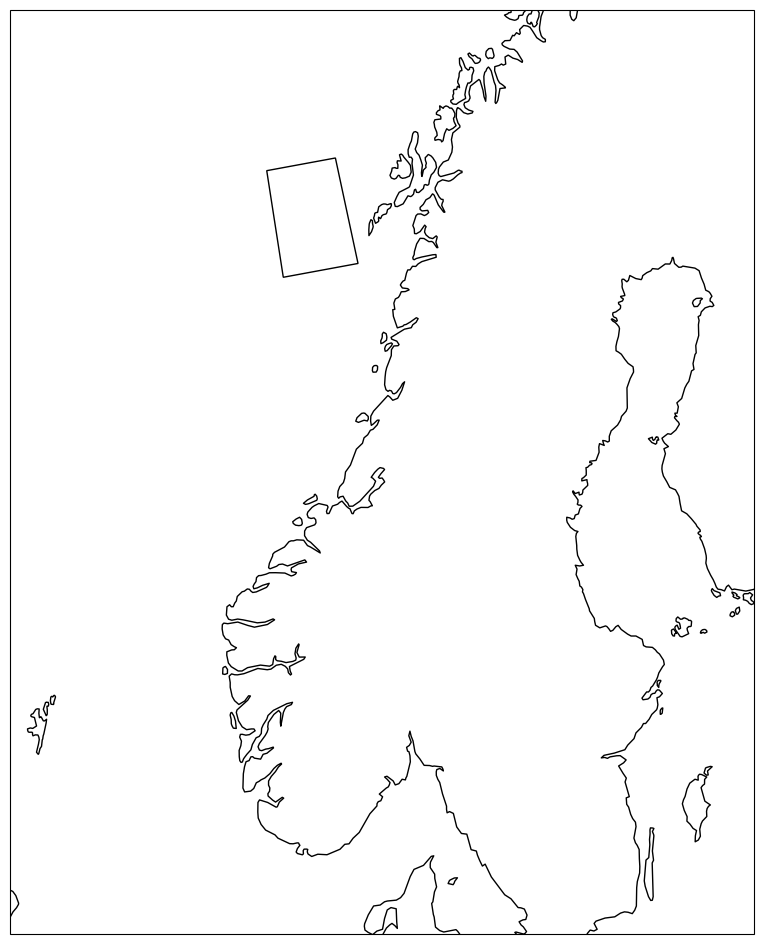

In [143]:
import matplotlib.patches as mpatches

fig,ax = plt.subplots(figsize = (10,12), subplot_kw={'projection': ccrs.NorthPolarStereo()})

lon = ds_norkyst.lon 
lat = ds_norkyst.lat


lon_llc = ds_norkyst.lon[-1,0].values; lat_llc = ds_norkyst.lat[-1,0].values #lower left corner
lon_lrc = ds_norkyst.lon[-1,-1].values; lat_lrc = ds_norkyst.lat[-1,-1].values #lower right corner
lon_ulc = ds_norkyst.lon[0,0].values; lat_ulc = ds_norkyst.lat[0,0].values #upper left corner 
lon_urc = ds_norkyst.lon[0,-1].values; lat_urc = ds_norkyst.lat[0, -1].values #upper right corner 

lon_ulc, lon_llc = 8.83, 8.83
lon_lrc, lon_urc = 12.1, 12.1
lat_urc, lat_ulc = 69.2, 69.2
lat_llc, lat_lrc = 67.41, 67.41

zipped_bep = zip([lon_llc, lon_lrc, lon_urc, lon_ulc, lon_llc], [lat_llc, lat_lrc, lat_urc, lat_ulc, lat_llc])

poly_beps = mpatches.Polygon(list(zipped_bep), closed=True,\
                        facecolor='none', edgecolor='black', lw=1, transform=ccrs.Geodetic(), zorder=2002) # it has to be clockwise, LLC first

ax.set_extent([-2,20,57,71])
ax.add_patch(poly_beps)
ax.coastlines()
ax.plot(ds_norkyst.lon, ds_norkyst.lat)

In [153]:
#Må finne en måte å oppgi disse lon og lat i form av X og Y
#ds_norkyst_selar = ds_norkyst.sel(lon = slice(8.83, 12.1), lat = slice(69.2, 67.41))

In [23]:
lon_ulc, lon_llc = 8.83, 8.83
lon_lrc, lon_urc = 12.1, 12.1
lat_urc, lat_ulc = 69.2, 69.2
lat_llc, lat_lrc = 67.41, 67.41
#lag om denne til def hvis det funker for lettere gjenbruk i spektrale analyser

#lon_re = ds_norkyst.lon.astype(np.float64)
#lat_re = ds_norkyst.lat.astype(np.float64)

ds_grid = pyresample.geometry.GridDefinition(lons=ds_norkyst.lon.values, lats = ds_norkyst.lat.values)
pos_geo = pyresample.geometry.SwathDefinition(lons=[lon_llc, lon_lrc, lon_urc, lon_ulc], lats=[lat_llc, lat_lrc, lat_urc, lat_ulc])

_, valid_output_index, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
                                                    source_geo_def = ds_grid,
                                                    target_geo_def = pos_geo,
                                                    radius_of_influence = 800,
                                                    neighbours = 1)

index_array_2d = np.unravel_index(index_array, ds_grid.shape)

(x_indices,y_indices) =  np.array([index_array_2d[0][0], index_array_2d[0][1], index_array_2d[0][2], index_array_2d[0][3]]), np.array([index_array_2d[1][0], index_array_2d[1][1], index_array_2d[1][2], index_array_2d[1][3]])
x_min, x_max = x_indices.min(), x_indices.max()
y_min, y_max = y_indices.min(), y_indices.max()

#make sure its correct
print(f'X min: {x_min}, X max: {x_max}')
print(f'Y min: {y_min}, Y max: {y_max}')

reshaped_norkyst_ds = ds_norkyst.isel(Y=slice(y_min, y_max+1), X = slice(x_min, x_max +1))


X min: 722, X max: 985
Y min: 1601, Y max: 1892


In [24]:
reshaped_norkyst_ds.head()

<xarray.Dataset> Size: 448B
Dimensions:           (time: 5, Y: 0, X: 5, s_w: 5)
Coordinates:
  * time              (time) datetime64[ns] 40B 2024-04-02 ... 2024-04-02T04:...
    s_rho             float64 8B -0.004904
  * X                 (X) float64 40B 5.776e+05 5.784e+05 ... 5.8e+05 5.808e+05
  * Y                 (Y) float64 0B 
  * s_w               (s_w) float64 40B -1.0 -0.96 -0.9208 -0.8823 -0.8446
    lon               (Y, X) float64 0B dask.array<chunksize=(0, 5), meta=np.ndarray>
    lat               (Y, X) float64 0B dask.array<chunksize=(0, 5), meta=np.ndarray>
Data variables: (12/18)
    Uwind_eastward    (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    Vwind_northward   (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    zeta              (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    ubar_eastward     (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    vbar_northward    (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    u_eastward        (time, Y, X) float32 0B dask.array<chunksize=(1, 0, 5), meta=np.ndarray>
    ...                ...
    hc                (time) float64 40B 100.0 100.0 100.0 100.0 100.0
    Cs_r              (time) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    Cs_w              (time, s_w) float64 200B dask.array<chunksize=(5, 5), meta=np.ndarray>
    h                 (time, Y, X) float32 0B dask.array<chunksize=(5, 0, 5), meta=np.ndarray>
    projection_stere  (time) int32 20B -2147483647 -2147483647 ... -2147483647
    depth             (time) int32 20B -2147483647 -2147483647 ... -2147483647
Attributes: (12/33)
    id:                      572391bb-878e-4153-bac1-2bd854d73fe4
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [25]:
sel_temp = reshaped_norkyst_ds["temperature"]
sel_temp = np.array(sel_temp)
sel_temp = np.mean(sel_temp, axis = 0)
dctarr = fftpack.dct(fftpack.dctn(sel_temp, type=2, norm = 'ortho'), axis=1, type=2, norm='ortho')

ValueError: invalid number of data points ([0, 264]) specified

In [14]:
if np.any(np.isnan(reshaped_norkyst_ds_temp)):
    print(f'There are nan values in temp')
#no nan values in the selected area

In [ ]:
spectral_variance(reshaped_norkyst_ds_temp, 0.8*0.8)

AttributeError: 'DataArray' object has no attribute 'flags'

 ...]

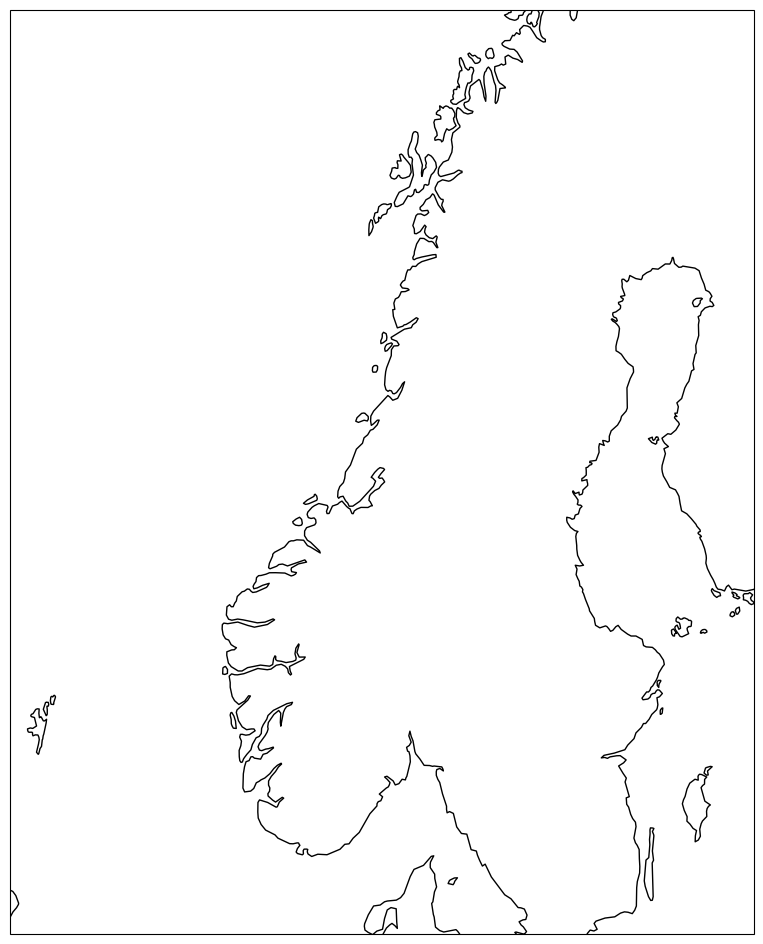

In [171]:
fig,ax = plt.subplots(figsize = (10,12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-2,20,57,71])
ax.coastlines()
ax.plot(reshaped_norkyst_ds.lon, reshaped_norkyst_ds.lat)
ax.plot(ds_norkyst.lon, ds_norkyst.lat)